<a href="https://colab.research.google.com/github/nithingit/Nithin_demo/blob/master/DL_Assignment1_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Import Libraries*

In [81]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
import spacy
import re
import matplotlib.pyplot as plt
import itertools

In [82]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [83]:
!nvidia-smi

Thu May 20 17:11:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W /  70W |   4478MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [84]:
# The spacy module needs to be installed
!pip install spacy

# The english module needs to be downloaded if not already
!python3 -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [85]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# *Import tweet Dataset*

In [86]:
# Read the dataset from google drive
df = pd.read_csv('/content/gdrive/My Drive/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", names = ['target','id','date','flag','user','text'], engine="python")

In [87]:
# Print first few rows of dataset
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [88]:
# Check the shape of dataset
df.shape

(1600000, 6)

# *Data Visualization*

In [89]:
# Print at least two movie reviews from each class of the dataset, for a sanity check that labels match the text

print("Negative reviews\n")
df_new = df[df['target'] == 0][:2]
  
print(df_new['text'])

print("\n")

print("Positive reviews\n")
df_new1 = df[df['target'] == 4][:2]
  
print(df_new1['text'])

Negative reviews

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
Name: text, dtype: object


Positive reviews

800000         I LOVE @Health4UandPets u guys r the best!! 
800001    im meeting up with one of my besties tonight! ...
Name: text, dtype: object


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa76f97ae90>]],
      dtype=object)

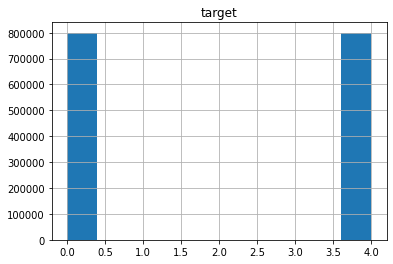

In [90]:
# Plot a bar graph of class distribution in dataset. Each bar depicts the number of tweets belonging to a particular sentiment
df.hist(["target"])

# *Data Pre-processing*

In [91]:
# Basic Info on the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [92]:
# Train Test Split

TRAINDOC = 210000

train_set =  df[['id', 'text', 'target']].sample(TRAINDOC)

xtrain_set = train_set.drop("target", axis=1)
ytrain_set = train_set[['target']].copy()

(X_train, X_test, y_train, y_test) = train_test_split(xtrain_set, ytrain_set, test_size= 0.3, stratify = ytrain_set, random_state = 101)

In [93]:
# Print the shape of train and test data

print('Train dataset shape: {}'.format(X_train.shape))
print('Test dataset shape: {}'.format(X_test.shape))

Train dataset shape: (147000, 2)
Test dataset shape: (63000, 2)


In [94]:
# Function for tweet preprocessing

def text_processing(tweet):
    
    # remove https links
    clean_tweet = re.sub(r'http\S+', '', tweet)
    # remove punctuation marks
    punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
    clean_tweet = ''.join(ch for ch in clean_tweet if ch not in set(punctuation))
    # convert text to lowercase
    clean_tweet = clean_tweet.lower()
    # remove numbers
    clean_tweet = re.sub('\d', ' ', clean_tweet)
    # remove whitespaces
    clean_tweet = ' '.join(clean_tweet.split())
    return clean_tweet

In [95]:
# import the english language model from spacy'
nlp = spacy.load('en', disable=['parser', 'ner'])

# function to lemmatize text
def lemmatization(tweets):
    lemma_tweet = []
    for i in tweets:
        t = [token.lemma_ for token in nlp(i)]
        lemma_tweet.append(' '.join(t))
    return lemma_tweet

In [96]:
X_train['clean_tweet'] = X_train['text'].apply(lambda x: text_processing(x))
X_test['clean_tweet'] = X_test['text'].apply(lambda x: text_processing(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [97]:
# Print first few rows of train set to see the clean tweet
X_train.head()

,id,text,clean_tweet
703342,2255678630,@mileycyrus Â£50 for a concert ticket to see y...,mileycyrus â£ for a concert ticket to see you ...
358343,2045236992,"Oh crap twiblets, my drive may have just had a...","oh crap twiblets, my drive may have just had a..."
99309,1793583442,i wish i was going to the great escape i wish...,i wish i was going to the great escape i wish ...
1263384,1999023841,"@TheTrueGem Hey! Thanks, I hope you have a gre...","thetruegem hey thanks, i hope you have a great..."
624326,2229862549,FOR THE LAST TIME; enclosed by the four walls ...,for the last time enclosed by the four walls o...


In [98]:
%%time
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

X_train['clean_tweet'] = X_train["clean_tweet"].apply(lambda x: lemmatizer_on_text(x))
X_test['clean_tweet'] = X_test["clean_tweet"].apply(lambda x: lemmatizer_on_text(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


CPU times: user 46.6 s, sys: 0 ns, total: 46.6 s
Wall time: 46.6 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [99]:
# GET clean tweet values
X_train = X_train["clean_tweet"].values
X_test = X_test["clean_tweet"].values

In [100]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [101]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [102]:
# Print first few rows of test set to see the clean tweet
X_test.shape

(63000,)

In [103]:
y_train.shape

(147000, 2)

# *Model Building*

In [104]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2",input_shape=[], output_shape=[128], dtype=tf.string)

model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(60, activation='relu'))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))

# Below indicate adding l2 regularizer
# model.add(keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01),activity_regularizer=tf.keras.regularizers.l2(0.01))) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 60)                7740      
_________________________________________________________________
dense_18 (Dense)             (None, 30)                1830      
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 62        
Total params: 124,668,832
Trainable params: 26,144
Non-trainable params: 124,642,688
___________________________________

# *Model Compilation*

In [105]:
# Compile the model with the appropriate loss function.

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# *Model Training*

In [106]:
%%time
hist = model.fit(X_train, y_train, epochs=40, batch_size=128, validation_split=0.2,verbose = 1)

Epoch 1/40
919/919 [==============================] - 5s 5ms/step - loss: 0.6037 - accuracy: 0.6644 - val_loss: 0.5471 - val_accuracy: 0.7204
Epoch 2/40
919/919 [==============================] - 5s 5ms/step - loss: 0.5571 - accuracy: 0.7116 - val_loss: 0.5393 - val_accuracy: 0.7286
Epoch 3/40
919/919 [==============================] - 5s 5ms/step - loss: 0.5457 - accuracy: 0.7224 - val_loss: 0.5348 - val_accuracy: 0.7312
Epoch 4/40
919/919 [==============================] - 5s 5ms/step - loss: 0.5375 - accuracy: 0.7262 - val_loss: 0.5289 - val_accuracy: 0.7348
Epoch 5/40
919/919 [==============================] - 5s 5ms/step - loss: 0.5335 - accuracy: 0.7290 - val_loss: 0.5293 - val_accuracy: 0.7324
Epoch 6/40
919/919 [==============================] - 5s 5ms/step - loss: 0.5277 - accuracy: 0.7324 - val_loss: 0.5237 - val_accuracy: 0.7370
Epoch 7/40
919/919 [==============================] - 5s 5ms/step - loss: 0.5269 - accuracy: 0.7344 - val_loss: 0.5229 - val_accuracy: 0.7370
Epoch 

In [107]:
print('Final training loss \t', hist.history['loss'][-1])
print('Final training accuracy ', hist.history['accuracy'][-1])

Final training loss 	 0.49033886194229126
Final training accuracy  0.7594302892684937


<function matplotlib.pyplot.show>

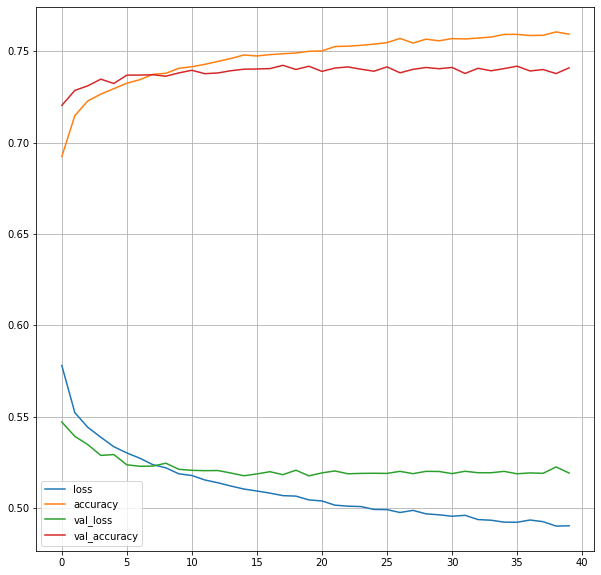

In [108]:
# Plot the loss and accuracy history graphs
pd.DataFrame(hist.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

# *Model Evaluation*

In [109]:
accuracy_test = model.evaluate(X_test, y_test, verbose=2)
print(accuracy_test)

1969/1969 - 5s - loss: 0.5251 - accuracy: 0.7384
[0.5251381993293762, 0.7384285926818848]


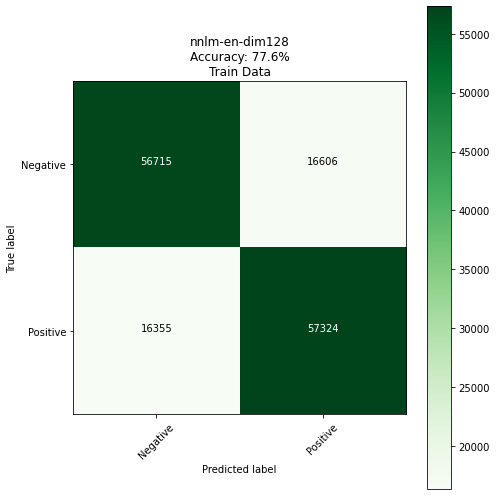

In [110]:
# Confusion Matrix
def plot_confusion_matrix(cm, 
                          classes, 
                          normalize=False,
                          title='CM', 
                          cmap=plt.cm.Greens):
# This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix") # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=45) 
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout() 
        plt.ylabel('True label') 
        plt.xlabel('Predicted label')

# np.argmax Returns the indices of the maximum values along an axis. 
y_test_rounded = np.argmax(y_test, axis=1)
y_train_rounded = np.argmax(y_train, axis=1)

y_pred = model.predict(X_train)
y_pred_rounded = np.argmax(y_pred, axis=1)

cmResults = confusion_matrix(y_train_rounded, y_pred_rounded) 
accuracy = accuracy_score(y_train_rounded, y_pred_rounded)

# Plot non-normalized confusion matrix 
class_names = ['Negative', 'Positive']
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, title=str("nnlm-en-dim128")+ "\n" +"Accuracy: " + str((accuracy*100).round(1)) + "%" +"\n"+"Train Data");

In [111]:
y_pred = model.predict(X_test)
y_pred_rounded = np.argmax(y_pred, axis=1)
cmResults = confusion_matrix(y_test_rounded, y_pred_rounded)
accuracy = accuracy_score(y_test_rounded, y_pred_rounded)

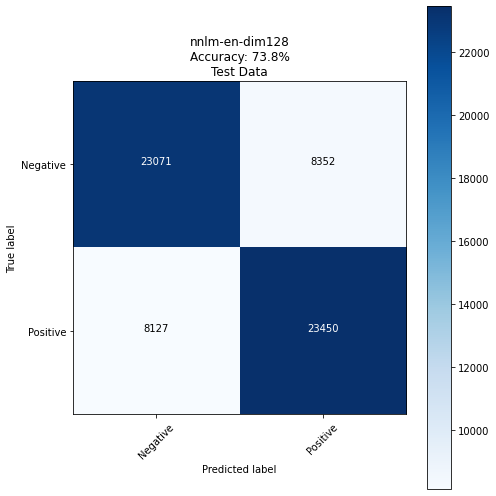

In [112]:
# Plot non-normalized confusion matrix 
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, 
                      title=str("nnlm-en-dim128")+ "\n" +"Accuracy: " + str((accuracy*100).round(1)) + "%" +"\n"+"Test Data",
                      cmap=plt.cm.Blues);

# *Hyperparameter Tuning*

In [113]:
from tensorflow.keras.optimizers import RMSprop

In [114]:
# Optimiser: Use a different optimizer with the appropriate LR valu
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

In [115]:
%%time
hist = model.fit(X_train, y_train, epochs=40, batch_size=128, validation_split=0.2,verbose = 1)

Epoch 1/40
919/919 [==============================] - 6s 6ms/step - loss: 0.4958 - accuracy: 0.7598 - val_loss: 0.5169 - val_accuracy: 0.7425
Epoch 2/40
919/919 [==============================] - 5s 5ms/step - loss: 0.4879 - accuracy: 0.7643 - val_loss: 0.5180 - val_accuracy: 0.7427
Epoch 3/40
919/919 [==============================] - 5s 5ms/step - loss: 0.4918 - accuracy: 0.7625 - val_loss: 0.5180 - val_accuracy: 0.7419
Epoch 4/40
919/919 [==============================] - 5s 6ms/step - loss: 0.4910 - accuracy: 0.7628 - val_loss: 0.5193 - val_accuracy: 0.7409
Epoch 5/40
919/919 [==============================] - 5s 5ms/step - loss: 0.4925 - accuracy: 0.7611 - val_loss: 0.5198 - val_accuracy: 0.7403
Epoch 6/40
919/919 [==============================] - 5s 6ms/step - loss: 0.4899 - accuracy: 0.7647 - val_loss: 0.5194 - val_accuracy: 0.7407
Epoch 7/40
919/919 [==============================] - 5s 6ms/step - loss: 0.4872 - accuracy: 0.7665 - val_loss: 0.5191 - val_accuracy: 0.7412
Epoch 

In [116]:
accuracy_test = model.evaluate(X_test, y_test, verbose=2)
print(accuracy_test)

1969/1969 - 5s - loss: 0.5276 - accuracy: 0.7356
[0.5276452302932739, 0.7356349229812622]


In [117]:
# Batch Size: Change the value of batch size in model training
hist = model.fit(X_train, y_train, epochs=40, batch_size=1000, validation_split=0.2,verbose = 1)

Epoch 1/40
118/118 [==============================] - 1s 10ms/step - loss: 0.4805 - accuracy: 0.7715 - val_loss: 0.5234 - val_accuracy: 0.7395
Epoch 2/40
118/118 [==============================] - 1s 9ms/step - loss: 0.4785 - accuracy: 0.7725 - val_loss: 0.5218 - val_accuracy: 0.7402
Epoch 3/40
118/118 [==============================] - 1s 9ms/step - loss: 0.4778 - accuracy: 0.7734 - val_loss: 0.5232 - val_accuracy: 0.7389
Epoch 4/40
118/118 [==============================] - 1s 9ms/step - loss: 0.4756 - accuracy: 0.7756 - val_loss: 0.5224 - val_accuracy: 0.7395
Epoch 5/40
118/118 [==============================] - 1s 9ms/step - loss: 0.4766 - accuracy: 0.7749 - val_loss: 0.5243 - val_accuracy: 0.7383
Epoch 6/40
118/118 [==============================] - 1s 9ms/step - loss: 0.4760 - accuracy: 0.7743 - val_loss: 0.5231 - val_accuracy: 0.7381
Epoch 7/40
118/118 [==============================] - 1s 9ms/step - loss: 0.4763 - accuracy: 0.7735 - val_loss: 0.5225 - val_accuracy: 0.7382
Epoch

In [118]:
accuracy_test = model.evaluate(X_test, y_test, verbose=2)
print(accuracy_test)

1969/1969 - 5s - loss: 0.5354 - accuracy: 0.7331
[0.5353732109069824, 0.7331428527832031]
